<a href="https://colab.research.google.com/github/deepw98/FrequencyWords/blob/master/PR1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r /content/drive/MyDrive/fire_detection_few_shot /content/fire_detection_few_shot

In [3]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split  # For creating validation split if needed
from tensorflow.keras.layers import RandomRotation  # Im

In [4]:
import cv2
import numpy as np
import os

def load_and_preprocess_image(image_path, target_size=(224, 224), augment=False):
    """Loads an image and preprocesses it for the Siamese Network while maintaining aspect ratio."""

    # Ensure image_path is a valid string
    if not isinstance(image_path, str):
        raise ValueError(f"Invalid image path type: {type(image_path)}. Expected a string.")

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at: {image_path}")

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get original dimensions
    original_height, original_width = img.shape[:2]
    target_height, target_width = target_size

    # Compute the scale to maintain aspect ratio
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize while keeping aspect ratio
    img_resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Create a black canvas and center the resized image
    img_padded = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    pad_top = (target_height - new_height) // 2
    pad_left = (target_width - new_width) // 2
    img_padded[pad_top:pad_top+new_height, pad_left:pad_left+new_width] = img_resized

    # Normalize
    img_padded = img_padded.astype('float32') / 255.0

    return img_padded


In [5]:
def create_image_pairs(fire_dir, non_fire_dir, target_size=(224, 224), augment_pairs=False):
    """
    Creates pairs of images (positive and negative) for Siamese network training.

    Args:
        fire_dir: Directory containing fire images.
        non_fire_dir: Directory containing non-fire images.
        target_size: Tuple (height, width) for resizing images.
        augment_pairs: Boolean, whether to augment images.

    Returns:
        Tuple: (pair_images, pair_labels)
               pair_images: List of image pairs (each pair is a NumPy array of two images).
               pair_labels: List of labels for pairs (0 for dissimilar, 1 for similar).
    """
    # 🔹 Extract directory if file paths are passed
    if isinstance(fire_dir, list):
        fire_dir = os.path.dirname(fire_dir[0])
    if isinstance(non_fire_dir, list):
        non_fire_dir = os.path.dirname(non_fire_dir[0])

    # 🔹 Now check directories
    if not os.path.exists(fire_dir) or not os.path.exists(non_fire_dir):
        raise ValueError(f"Invalid directory paths:\nFire: {fire_dir}\nNon-Fire: {non_fire_dir}")

    # Get image file paths
    fire_images = [os.path.join(fire_dir, f) for f in os.listdir(fire_dir) if os.path.isfile(os.path.join(fire_dir, f))]
    non_fire_images = [os.path.join(non_fire_dir, f) for f in os.listdir(non_fire_dir) if os.path.isfile(os.path.join(non_fire_dir, f))]

    if not fire_images or not non_fire_images:
        raise ValueError("Error: One of the classes has no images. Check dataset paths.")

    pair_images = []
    pair_labels = []

    # Positive Pairs (Fire-Fire and Non-Fire-Non-Fire)
    min_len = min(len(fire_images), len(non_fire_images))  # To balance positive pairs
    for i in range(min_len):
        # Fire - Fire Pair
        img1_fire = load_and_preprocess_image(fire_images[i], target_size, augment=augment_pairs)
        img2_fire = load_and_preprocess_image(fire_images[(i + 1) % len(fire_images)], target_size, augment=augment_pairs)
        pair_images.append(np.array([img1_fire, img2_fire]))
        pair_labels.append(1)  # Similar (Fire-Fire)

        # Non-Fire - Non-Fire Pair
        img1_non_fire = load_and_preprocess_image(non_fire_images[i], target_size, augment=augment_pairs)
        img2_non_fire = load_and_preprocess_image(non_fire_images[(i + 1) % len(non_fire_images)], target_size, augment=augment_pairs)
        pair_images.append(np.array([img1_non_fire, img2_non_fire]))
        pair_labels.append(1)  # Similar (Non-Fire-Non-Fire)

    # Negative Pairs (Fire-Non-Fire)
    for i in range(min_len * 2):  # Create more negative pairs
        img_fire = load_and_preprocess_image(fire_images[i % len(fire_images)], target_size, augment=augment_pairs)
        img_non_fire = load_and_preprocess_image(non_fire_images[i % len(non_fire_images)], target_size, augment=augment_pairs)
        pair_images.append(np.array([img_fire, img_non_fire]))
        pair_labels.append(0)  # Dissimilar (Fire-Non-Fire)

    return np.array(pair_images), np.array(pair_labels)  # Return as NumPy arrays

In [7]:
#def prepare_data_for_training(train_fire_dir, train_non_fire_dir, test_fire_dir, test_non_fire_dir, target_size=(224, 224), augment_train_pairs=True):
def prepare_data_for_training(train_fire_dir, train_non_fire_dir,
                              test_fire_dir, test_non_fire_dir,
                              target_size=(224, 224), augment_train_pairs=True):
    """
    Prepares training and testing data, creating image pairs and labels.

    Args:
        train_fire_dir: Directory for training fire images.
        train_non_fire_dir: Directory for training non-fire images.
        test_fire_dir: Directory for testing fire images.
        test_non_fire_dir: Directory for testing non-fire images.
        target_size: Image resize target size.
        augment_train_pairs: Whether to augment training image pairs.

    Returns:
        Tuple: (train_pairs, train_labels, test_pairs, test_labels, image_paths)
    """

   # train_pairs, train_labels, train_image_paths = create_image_pairs(train_fire_dir, train_non_fire_dir, target_size=target_size, augment_pairs=augment_train_pairs)
    train_pairs, train_labels = create_image_pairs(
        train_fire_dir, train_non_fire_dir, target_size=target_size, augment_pairs=augment_train_pairs
    )
    print("Number of training pairs:", len(train_pairs))

    test_pairs, test_labels = create_image_pairs(
        test_fire_dir, test_non_fire_dir, target_size=target_size, augment_pairs=False  # No augmentation for test
    )

    # Convert lists to NumPy arrays for TensorFlow
    train_pairs = np.array(train_pairs)
    train_labels = np.array(train_labels)
    test_pairs = np.array(test_pairs)
    test_labels = np.array(test_labels)

  #  image_paths = {'train': train_image_paths, 'test': test_image_paths}

    print(f"Number of Training Pairs: {len(train_pairs)}")
    print(f"Number of Testing Pairs: {len(test_pairs)}")

    return train_pairs, train_labels, test_pairs, test_labels

# ---  Directory paths (Replace with your actual paths) ---
train_fire_dir = '/content/fire_detection_few_shot/train/Fire'  # <--- REPLACE
train_non_fire_dir = '/content/fire_detection_few_shot/train/No_Fire' # <--- REPLACE
test_fire_dir = '/content/fire_detection_few_shot/test/Fire'    # <--- REPLACE
test_non_fire_dir = '/content/fire_detection_few_shot/test/No_Fire'  # <--- REPLACE

# --- Prepare the data ---
target_image_size = (224, 224) # Or (128, 128) for faster training with small data

train_pair_data, train_pair_labels, test_pair_data, test_pair_labels = prepare_data_for_training(
    train_fire_dir, train_non_fire_dir, test_fire_dir, test_non_fire_dir, target_size=target_image_size, augment_train_pairs=True
)

# --- Data is now ready for training ---
print("\nData Preprocessing Complete. Data is ready for Siamese Network training.")
print("Example of a training pair shape:", train_pair_data[0].shape) # Should be (2, 224, 224, 3) if target_size=(224, 224) and RGB
print("Example of a training pair label:", train_pair_labels[0])

Number of training pairs: 568
Number of Training Pairs: 568
Number of Testing Pairs: 40

Data Preprocessing Complete. Data is ready for Siamese Network training.
Example of a training pair shape: (2, 224, 224, 3)
Example of a training pair label: 1


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Layer, GlobalAveragePooling2D, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow.keras.layers import Layer, concatenate
from tensorflow.keras import backend as K

class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super(DistanceLayer, self).__init__(**kwargs)

    def call(self, embeddings):
        embedding_1, embedding_2 = embeddings

        # Ensure correct tensor shapes
        embedding_1 = tf.reshape(embedding_1, (-1, 1280))
        embedding_2 = tf.reshape(embedding_2, (-1, 1280))

        # Euclidean Distance (Squared L2 Norm)
        euclidean_distance = tf.reduce_sum(tf.square(embedding_1 - embedding_2), axis=-1, keepdims=True)

        # Cosine Similarity
        x = K.l2_normalize(embedding_1, axis=-1)
        y = K.l2_normalize(embedding_2, axis=-1)
        cosine_similarity = -tf.reduce_sum(x * y, axis=-1, keepdims=True)

        # Manhattan Distance (L1 Norm)
        manhattan_distance = tf.reduce_sum(tf.abs(embedding_1 - embedding_2), axis=-1, keepdims=True)

        # Ensure output shape is consistent (Batch, 3)
        return concatenate([euclidean_distance, cosine_similarity, manhattan_distance], axis=-1)

    def get_config(self):
        return super().get_config()



In [9]:
def build_efficientnet_encoder(input_shape):
    """
    Builds the EfficientNet-B0 encoder backbone.

    Args:
        input_shape: Shape of the input images (e.g., (224, 224, 3)).

    Returns:
        Keras Model: EfficientNet-B0 encoder model.
    """
    efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    # Freeze initial layers (optional, for fine-tuning strategy)
    # for layer in efficientnet.layers[:(len(efficientnet.layers) // 2)]: # Freeze first half of layers - Example
    #     layer.trainable = False

    input_tensor = Input(shape=input_shape)
    embedding = efficientnet(input_tensor)
    embedding = GlobalAveragePooling2D()(embedding) # Get embedding vector after GAP
    # embedding = Dense(128)(embedding) # Optional: Add a dense layer to further process/reduce embedding dimensionality if needed - experiment with or without

    return Model(input_tensor, embedding)


In [ ]:
# def build_siamese_model(input_shape, distance_weights=None):
#     """
#     Builds the Siamese Network model.

#     Args:
#         input_shape: Shape of input images.
#         distance_weights: Weights for combining distance metrics (e.g., [0.33, 0.33, 0.34]).
#                          If None, defaults to equal weights.

#     Returns:
#         Keras Model: Siamese network model.
#     """
#     encoder = build_efficientnet_encoder(input_shape)
#     print("Output shape of encoder model:", encoder.output_shape) # ADD THIS LINE

#     # Input layers for each image in the pair
#     input_image_1 = Input(shape=input_shape, name="image_1_input")
#     input_image_2 = Input(shape=input_shape, name="image_2_input")

#     # Embeddings for each image
#     embedding_1 = encoder(input_image_1)
#     embedding_2 = encoder(input_image_2)

#     # Distance layer
#     distance_vector = DistanceLayer()([embedding_1, embedding_2])

#     # Weighted Distance Combination (Ensemble)
#     if distance_weights is None:
#         distance_weights = [0.33, 0.33, 0.34] # Default equal weights
#     weighted_distance = Dense(1, activation='linear', use_bias=False,
#                              kernel_initializer=tf.keras.initializers.Constant(value=[distance_weights]))(distance_vector) # Linear layer with fixed weights

#     # Output is the weighted distance - you'll use a threshold on this for classification during inference
#     siamese_output = weighted_distance

#     return Model(inputs=[input_image_1, input_image_2], outputs=siamese_output)


In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Register DistanceLayer
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({"DistanceLayer": DistanceLayer})

def build_siamese_model(input_shape, distance_weights=None):
    """
    Builds the Siamese Network model.

    Args:
        input_shape: Shape of input images.
        distance_weights: Weights for combining distance metrics (e.g., [0.33, 0.33, 0.34]).
                         If None, defaults to equal weights.

    Returns:
        Keras Model: Siamese network model.
    """
    encoder = build_efficientnet_encoder(input_shape)
    print("Output shape of encoder model:", encoder.output_shape)  # Debugging

    # Input layers for each image in the pair
    input_image_1 = Input(shape=input_shape, name="image_1_input")
    input_image_2 = Input(shape=input_shape, name="image_2_input")

    # Embeddings for each image
    embedding_1 = encoder(input_image_1)
    embedding_2 = encoder(input_image_2)

    # Distance layer
    distance_vector = DistanceLayer()([embedding_1, embedding_2])

    # Weighted Distance Combination (Ensemble)
    if distance_weights is None:
        distance_weights = [0.33, 0.33, 0.34]  # Default equal weights
    distance_weights = np.array(distance_weights).reshape(-1, 1)  # Ensure correct shape

    weighted_distance = Dense(1, activation='linear', use_bias=False,
                              kernel_initializer=tf.keras.initializers.Constant(value=distance_weights))(distance_vector)

    # Output is the weighted distance - you'll use a threshold on this for classification during inference
    siamese_output = weighted_distance

    return Model(inputs=[input_image_1, input_image_2], outputs=siamese_output)


In [11]:
input_shape = (224, 224, 3) # Match your image input size
siamese_model = build_siamese_model(input_shape)

# Optional: Visualize the model architecture
tf.keras.utils.plot_model(siamese_model, to_file='siamese_model_architecture.png', show_shapes=True, show_layer_names=True, dpi=60)
print("Siamese Model Architecture visualized and saved as 'siamese_model_architecture.png'")

# Print model summary
siamese_model.summary()

Output shape of encoder model: (None, 1280)
Siamese Model Architecture visualized and saved as 'siamese_model_architecture.png'


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_1_input             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_2_input             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 1280)           │      4,049,571 │ image_1_input[0][0],   │
│                           │                        │                │ image_2_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distance_layer            │ (None, 3)              │              0 │ functional[0][0],      │
│ (DistanceLayer)           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │              3 │ distance_layer[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,049,574 (15.45 MB)

 Trainable params: 4,007,551 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [12]:
import tensorflow as tf

def contrastive_loss(y_true, distance, margin=1.0):
    """
    Contrastive Loss function.

    Args:
        y_true: True labels for pairs (1 for similar, 0 for dissimilar).
        distance: Distance output from the Siamese network for each pair.
        margin: Margin value for dissimilar pairs.

    Returns:
        TensorFlow scalar: Contrastive loss value.
    """
    # Cast y_true to float32 to ensure it's compatible with TensorFlow operations
    y_true = tf.cast(y_true, tf.float32)

    # Loss for similar pairs (y_true == 1)
    square_pred = tf.square(distance)
    margin_square = tf.square(tf.maximum(0.0, margin - distance)) # max(0, margin - distance)^2
    loss_similar = y_true * square_pred  # If y_true == 1, apply square_pred loss

    # Loss for dissimilar pairs (y_true == 0)
    loss_dissimilar = (1 - y_true) * margin_square # If y_true == 0, apply margin_square loss


    loss = tf.reduce_mean(loss_similar + loss_dissimilar) # Average loss over all pairs in the batch
    return loss

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # Adam optimizer is a good starting point

# ... (Your DistanceLayer, build_efficientnet_encoder, build_siamese_model, and contrastive_loss function definitions from previous steps should be here) ...

# --- Build the Siamese Model (already done) ---
input_shape = (224, 224, 3)
siamese_model = build_siamese_model(input_shape)

# --- Compile the Siamese Model ---
optimizer = Adam(learning_rate=0.0001) # Choose Adam optimizer, experiment with learning rate

siamese_model.compile(optimizer=optimizer,
                      loss=contrastive_loss) # Use your contrastive_loss function

print("Siamese Model Compiled!")

Output shape of encoder model: (None, 1280)
Siamese Model Compiled!


In [14]:
import os

def get_image_paths(folder):
    """
    Get all image file paths from a given directory.
    """
    image_extensions = (".jpg", ".jpeg", ".png")  # Modify if needed
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(image_extensions)]

# Get image paths
fire_images = get_image_paths("/content/fire_detection_few_shot/train/Fire")
no_fire_images = get_image_paths("/content/fire_detection_few_shot/train/No_Fire")

print(f"Found {len(fire_images)} fire images and {len(no_fire_images)} no-fire images.")


Found 152 fire images and 142 no-fire images.


In [15]:
import numpy as np
import tensorflow as tf

def create_few_shot_task(fire_images, no_fire_images, N=2, K=5, Q=1):
    """
    Creates an episodic task for few-shot learning.

    Args:
        fire_images: List of fire image paths.
        no_fire_images: List of no-fire image paths.
        N: Number of classes per episode (2-way: fire vs. no-fire).
        K: Number of support examples per class.
        Q: Number of query examples per class.

    Returns:
        support_set: Support set images (N*K images).
        query_set: Query set images (N*Q images).
        labels: Corresponding labels for query set.
    """
    fire_samples = np.random.choice(fire_images, K + Q, replace=False)
    no_fire_samples = np.random.choice(no_fire_images, K + Q, replace=False)

    # Create support and query sets
    support_set = np.concatenate([fire_samples[:K], no_fire_samples[:K]])
    query_set = np.concatenate([fire_samples[K:], no_fire_samples[K:]])
    labels = np.array([1] * Q + [0] * Q)  # 1 for fire, 0 for no-fire

    return support_set, query_set, labels


In [16]:
def episodic_training(model, fire_images, no_fire_images, epochs=1000, K=5, Q=1):
    """Performs episodic training for few-shot learning."""

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        try:
            fire_sample = np.random.choice(fire_images, K, replace=False)
            no_fire_sample = np.random.choice(no_fire_images, K, replace=False)
        except ValueError:
            print("Not enough images for the chosen K value.")
            continue

        fire_batch = np.array([load_and_preprocess_image(img) for img in fire_sample])
        no_fire_batch = np.array([load_and_preprocess_image(img) for img in no_fire_sample])

        # Training step placeholder (model logic should be here)
        print(f"Training with {len(fire_batch)} fire and {len(no_fire_batch)} no-fire images.")

    print("Training complete.")

In [17]:


# Train the model with few-shot learning
episodic_training(siamese_model, fire_images, no_fire_images, epochs=1000, K=5, Q=1)


Epoch 1/1000
Training with 5 fire and 5 no-fire images.
Epoch 2/1000
Training with 5 fire and 5 no-fire images.
Epoch 3/1000
Training with 5 fire and 5 no-fire images.
Epoch 4/1000
Training with 5 fire and 5 no-fire images.
Epoch 5/1000
Training with 5 fire and 5 no-fire images.
Epoch 6/1000
Training with 5 fire and 5 no-fire images.
Epoch 7/1000
Training with 5 fire and 5 no-fire images.
Epoch 8/1000
Training with 5 fire and 5 no-fire images.
Epoch 9/1000
Training with 5 fire and 5 no-fire images.
Epoch 10/1000
Training with 5 fire and 5 no-fire images.
Epoch 11/1000
Training with 5 fire and 5 no-fire images.
Epoch 12/1000
Training with 5 fire and 5 no-fire images.
Epoch 13/1000
Training with 5 fire and 5 no-fire images.
Epoch 14/1000
Training with 5 fire and 5 no-fire images.
Epoch 15/1000
Training with 5 fire and 5 no-fire images.
Epoch 16/1000
Training with 5 fire and 5 no-fire images.
Epoch 17/1000
Training with 5 fire and 5 no-fire images.
Epoch 18/1000
Training with 5 fire and 5

In [22]:
results = siamese_model.evaluate(test_dataset)
print("Evaluation Results:", results)


NameError: name 'test_dataset' is not defined

In [18]:
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        embedding_1, embedding_2 = inputs
        return tf.math.abs(embedding_1 - embedding_2)

    def get_config(self):
        config = super().get_config()
        return config


In [19]:
tf.keras.utils.get_custom_objects()["DistanceLayer"] = DistanceLayer


In [20]:
siamese_model.save('siamese_model.h5', save_format='h5')


In [21]:
from tensorflow.keras.saving import load_model

model = load_model("siamese_model.h5", custom_objects={"DistanceLayer": DistanceLayer})


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [3,1] vs. [1280,1] [Op:Mul] name: 

In [26]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, confusion_matrix

# Load model
# model = tf.keras.models.load_model("")  # Adjust path if needed

# Paths to test dataset
test_fire_path = "fire_detection_few_shot/test/Fire"
test_no_fire_path = "fire_detection_few_shot/test/No_Fire"

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0  # Normalize
    return img

# Load test images
fire_images = [os.path.join(test_fire_path, img) for img in os.listdir(test_fire_path)]
no_fire_images = [os.path.join(test_no_fire_path, img) for img in os.listdir(test_no_fire_path)]

# Create similar and dissimilar pairs
pairs = []
labels = []

for img1 in fire_images:
    for img2 in fire_images:
        if img1 != img2:
            pairs.append((img1, img2))
            labels.append(1)  # Similar (both fire)

for img1 in no_fire_images:
    for img2 in no_fire_images:
        if img1 != img2:
            pairs.append((img1, img2))
            labels.append(1)  # Similar (both no-fire)

for img1 in fire_images:
    for img2 in no_fire_images:
        pairs.append((img1, img2))
        labels.append(0)  # Dissimilar (fire vs no-fire)

# Convert to numpy arrays
X1 = np.array([load_and_preprocess_image(p[0]) for p in pairs])
X2 = np.array([load_and_preprocess_image(p[1]) for p in pairs])
labels = np.array(labels)

# Predict similarity scores
predictions = siamese_model.predict([X1, X2])
predictions = predictions.flatten()

# Choose a threshold (experiment with values)
threshold = 0.5
predicted_labels = (predictions >= threshold).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average="binary")

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")



9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step
Accuracy: 0.3786
Precision: 0.6000
Recall: 0.1000
F1-score: 0.1714
AUC-ROC: 0.5009


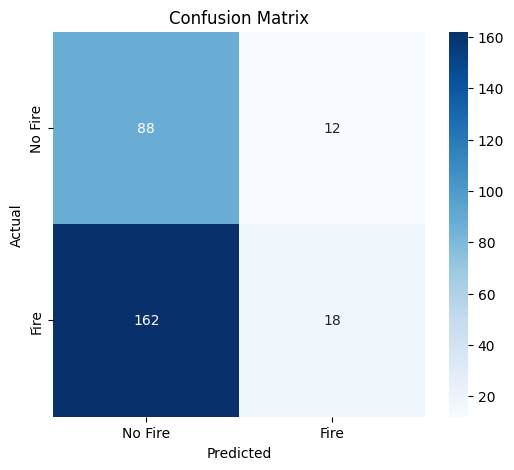

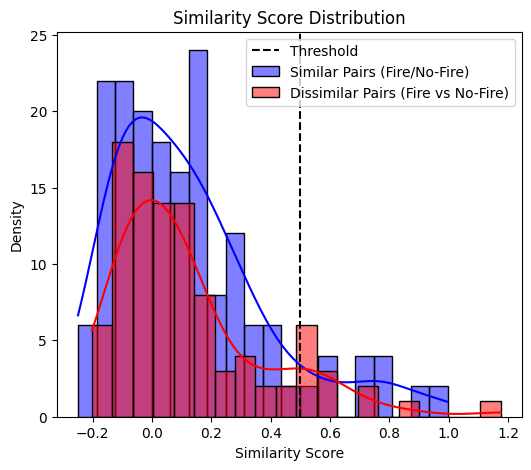

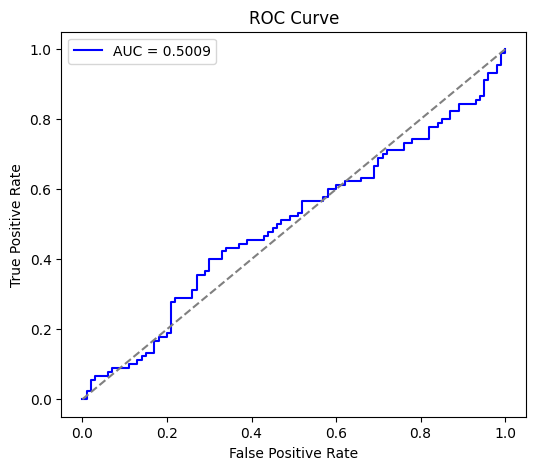

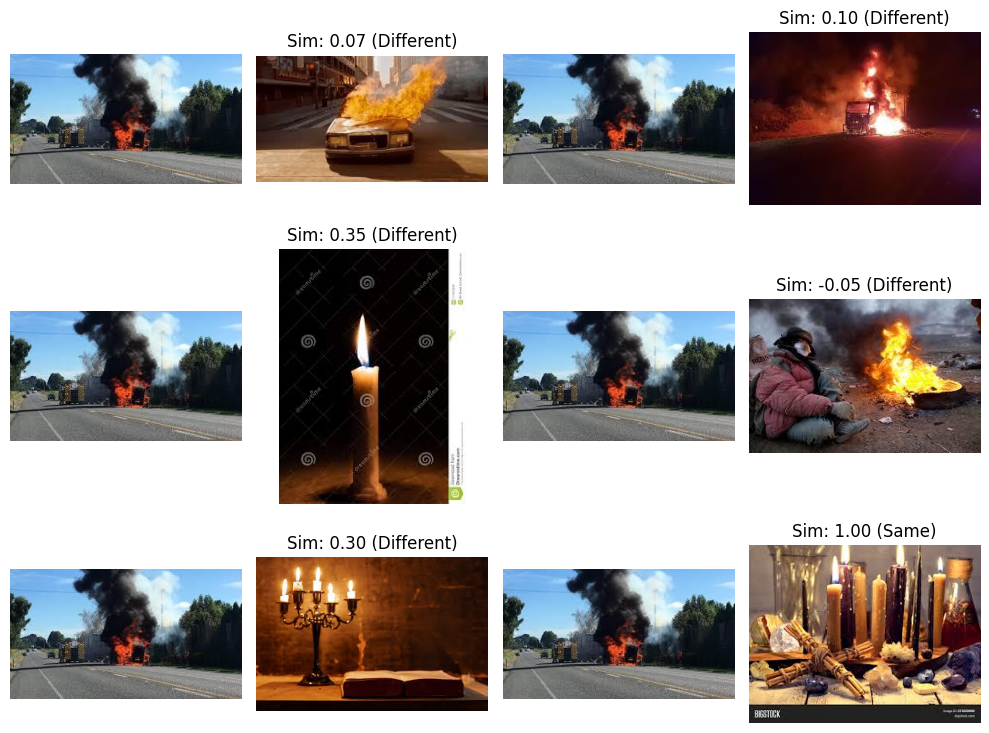

In [27]:
# Visualization

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(labels, predicted_labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Similarity Score Distribution
plt.figure(figsize=(6,5))
sns.histplot(predictions[labels == 1], label="Similar Pairs (Fire/No-Fire)", color="blue", kde=True, bins=20)
sns.histplot(predictions[labels == 0], label="Dissimilar Pairs (Fire vs No-Fire)", color="red", kde=True, bins=20)
plt.axvline(threshold, color="black", linestyle="dashed", label="Threshold")
plt.legend()
plt.title("Similarity Score Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.show()

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="dashed")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Show sample predictions
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes = axes.ravel()

for i in range(6):  # Show 6 example pairs
    img1 = cv2.imread(pairs[i][0])
    img2 = cv2.imread(pairs[i][1])

    axes[i * 2].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[i * 2].axis("off")
    axes[i * 2 + 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[i * 2 + 1].axis("off")

    similarity = predictions[i]
    label = "Same" if predicted_labels[i] == 1 else "Different"
    axes[i * 2 + 1].set_title(f"Sim: {similarity:.2f} ({label})")

plt.tight_layout()
plt.show()
